# Class 15 - Solution Code

Exploring Rossmann Drug Store Sales Data

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

### Load Dataset and Pre-Process

We will use the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) dataset for this exercise.  

Data Dictionary from Kaggle  

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


We will use a subset of these features for this exercise.

In [2]:
# Load data
data = pd.read_csv('../../data/rossmann.csv', skipinitialspace=True, low_memory=False)

# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [3]:
# Convert to datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Use `Date` as index
data.set_index('Date', inplace=True)

# Add extra columns to break out month and year
data['Year'] = data.index.year
data['Month'] = data.index.month

Using the date as index allows us to filter easily

In [4]:
# Filter for a particular year
data['2014'].head()

# Or month
data['2014-05'].head()

# Or date
data['2014-06-22'].head()

/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_10791/1200288056.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['2014'].head()
/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_10791/1200288056.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['2014-05'].head()
/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_10791/1200288056.py:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['2014-06-22'].head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2014-06-22,1,7,0,0,0,0,0,0,2014,6
2014-06-22,2,7,0,0,0,0,0,0,2014,6
2014-06-22,3,7,0,0,0,0,0,0,2014,6
2014-06-22,4,7,0,0,0,0,0,0,2014,6
2014-06-22,5,7,0,0,0,0,0,0,2014,6


There are over a million sales data points in this dataset, so for some analysis we will focus on just one store.

In [5]:
# Filter for a single store
store1_data = data[data['Store'] == 1]

# Check sample
store1_data.sample(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2014-02-24,1,1,3826,481,1,0,0,0,2014,2
2014-06-15,1,7,0,0,0,0,0,0,2014,6
2015-03-18,1,3,3858,504,1,1,0,0,2015,3
2014-10-06,1,1,5402,608,1,1,0,0,2014,10
2014-12-15,1,1,8069,871,1,1,0,0,2014,12


# Part 1: Data Exploration and Mining

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days. On state holidays the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


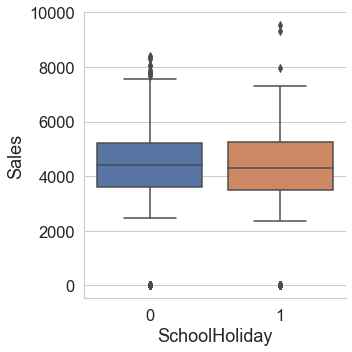

In [6]:
# Plot sales vs school holiday
sns.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box')

**Check**: See if there is a difference affecting sales on promotion days.

/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


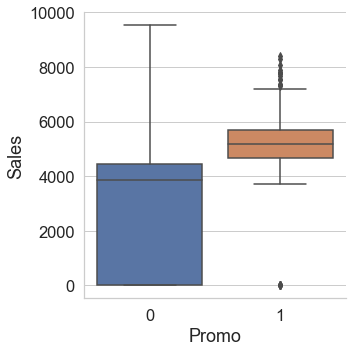

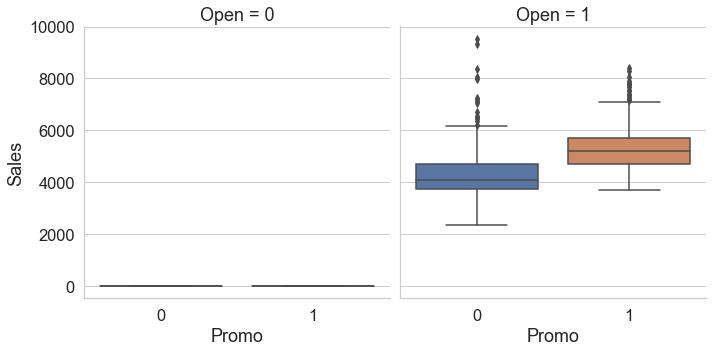

In [7]:
# Plot sales vs promotion days
sns.factorplot(
    x='Promo',
    y='Sales',
    data=store1_data, 
    kind='box')

# Plot sales vs promotion days for only days when store is open
sns.factorplot(
    col='Open',
    x='Promo',
    y='Sales',
    data=store1_data, 
    kind='box')

Compare sales across days of the week

/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


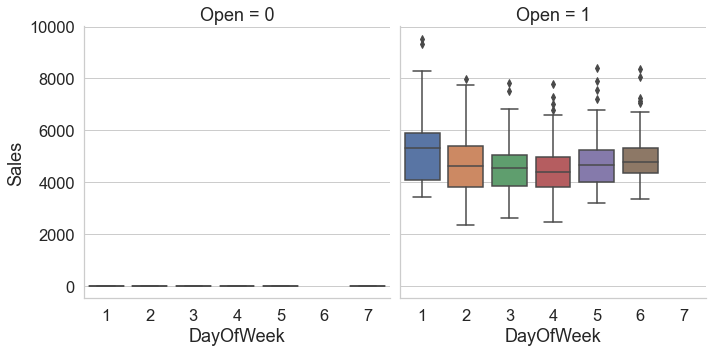

In [8]:
# Plot sales vs day of week
sns.factorplot(
    col='Open',
    x='DayOfWeek',
    y='Sales',
    data=store1_data,
    kind='box')

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

<AxesSubplot:xlabel='Date'>

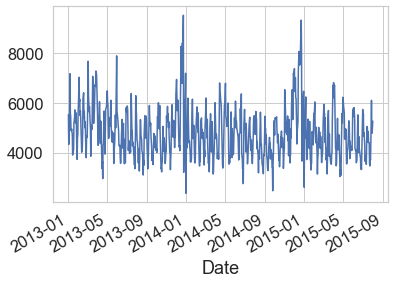

In [9]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]

# Plot sales over time
store1_open_data['Sales'].plot()

<AxesSubplot:xlabel='Date'>

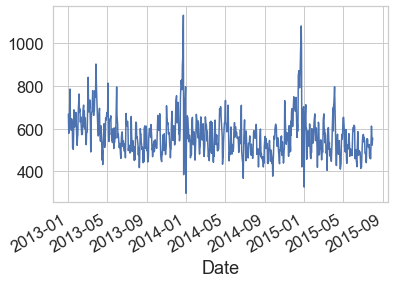

In [10]:
# Plot customer visits over time
store1_open_data['Customers'].plot()

**Check**: Use the index filtering to filter to just 2014.  Zoom in on changes over time. Is it easier to identify the holiday sales bump?

/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_10791/1542921144.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  store1_open_data['2014']['Sales'].plot()


<AxesSubplot:xlabel='Date'>

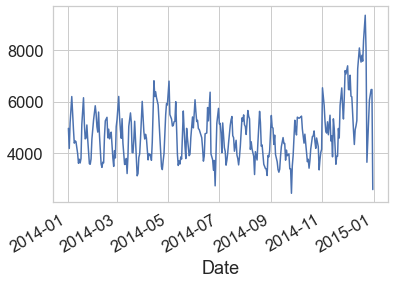

In [11]:
# Plot sales over time for 2014
store1_open_data['2014']['Sales'].plot()

# Part 2: Data Refining Using Time Series Statistics

**Warning** Prior to version 0.18.0, pd.rolling_*, pd.expanding_*, and pd.ewm* were module level functions and are now deprecated. These are replaced by using the Rolling, Expanding and EWM. objects and a corresponding method call.
The deprecation warning will show the new syntax, see an example [here](http://pandas.pydata.org/pandas-docs/stable/whatsnew.html#whatsnew-0180-window-deprecations).

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the autocorrelation of the 'Sales' column. In pandas, we do this we with the autocorr function.  
`autocorr` takes one argument, the `lag` - which is how many prior data points should be used to compute the correlation. If we set the lag to 1, we compute the correlation between every point and the point directly preceding it, while setting lag to 10, computes the correlation between every point and the point 10 days earlier.

In [12]:
# Daily correlation
print (store1_data['Sales'].resample('D').mean().autocorr(lag=1))

# Weekly correlation
print (store1_data['Sales'].resample('D').mean().autocorr(lag=7))

-0.12732514339140213
0.6307192432840288


### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  We want to know what the mean and median sales were for each month and year.

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [13]:
store1_data['2014'][['Sales']].resample('M').mean().add_suffix('_Mean').head()

/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_10791/899899077.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  store1_data['2014'][['Sales']].resample('M').mean().add_suffix('_Mean').head()


,Sales_Mean
Date,
2014-01-31,3832.709677
2014-02-28,3944.071429
2014-03-31,3757.000000
2014-04-30,3843.066667
2014-05-31,3797.258065


In [14]:
store1_data['2014'][['Sales']].resample('M').median().add_suffix('_Median').head()

/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_10791/2327804796.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  store1_data['2014'][['Sales']].resample('M').median().add_suffix('_Median').head()


,Sales_Median
Date,
2014-01-31,4454.0
2014-02-28,4624.5
2014-03-31,4023.0
2014-04-30,4061.5
2014-05-31,4298.0


/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_10791/1856335047.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  store1_data['2014']['Sales'].resample('D').mean().plot()


<AxesSubplot:xlabel='Date'>

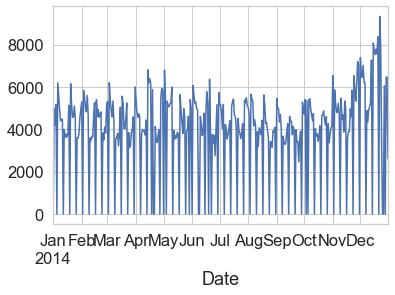

In [15]:
store1_data['2014']['Sales'].resample('D').mean().plot()

While identifying the monthly averages are useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

`rolling_mean` (as well as `rolling_median`) takes these important parameters:
- the first is the series to aggregate
- `window` is the number of days to include in the average
- `center` is whether the window should be centered on the date or use data prior to that date
- `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

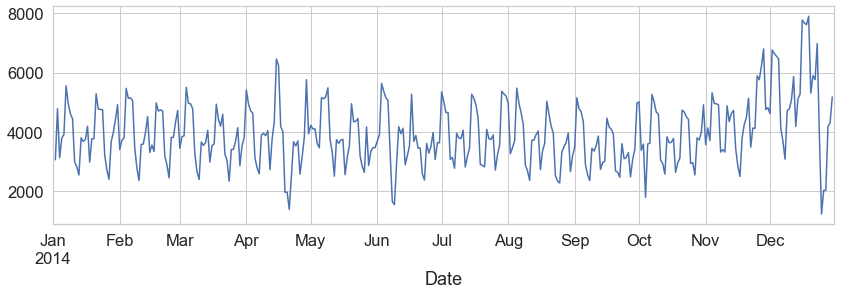

In [16]:
plt.subplots(figsize=(14, 4)) 
store1_data.loc['2014']['Sales'].rolling(window=3, center=True).mean().plot();

As we discussed earlier, this averages all values in the window evenly.  However we may want to weight closer values more.

For example, for a centered weighted average of 10 days, we want to put emphasis on +/- 1 day versus +/- 5 days.

One option to do that is the ewma function or the exponential weighted moving average function.

<AxesSubplot:xlabel='Date'>

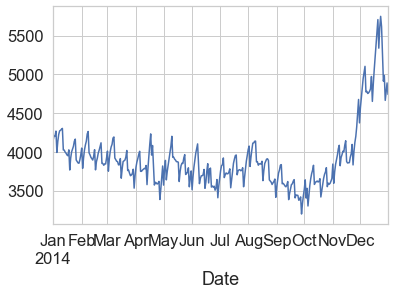

In [17]:
store1_data['Sales'][::-1].ewm( span=30).mean()['2014'].plot()

### Diff
Pandas `rolling().mean()` and `rolling().median()` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling().mean()` and `rolling().median()`, there are `rolling().sum()`, `rolling().min()`, `rolling().max()`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many prior rows to use for the difference.


In [18]:
# Difference in sales, day by day
store1_data[['Sales']].resample('D').mean().diff(periods=1).head(10)

,Sales
Date,
2013-01-01,NaN
2013-01-02,5530.0
2013-01-03,-1203.0
2013-01-04,159.0
2013-01-05,511.0
2013-01-06,-4997.0
2013-01-07,7176.0
2013-01-08,-1596.0
2013-01-09,-109.0


In [19]:
# Difference in sales, each day to the same day in the previous week
store1_data[['Sales']].resample('D').mean().diff(periods=7).head(10)

,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
2013-01-06,NaN
2013-01-07,NaN
2013-01-08,5580.0
2013-01-09,-59.0


### Expanding functions

In addition to the set of `rolling()` functions, Pandas also provides a similar collection of `expanding()` functions, which, instead of using a window of N values, use all values up until that time.

<AxesSubplot:xlabel='Date'>

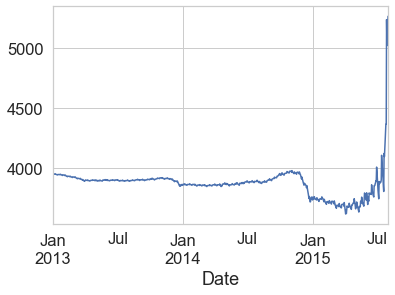

In [20]:
# Mean of all previous values at each point
store1_data['Sales'].expanding(min_periods=1).mean().plot()

# Part 3: Exercises

### 3.1 Plot the distribution of sales by month and compare the effect of promotions

/Users/champions2019/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


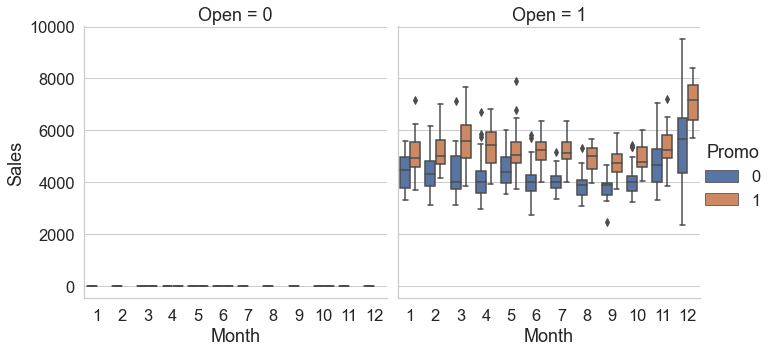

In [21]:
sns.factorplot(
    col='Open',
    hue='Promo',
    x='Month',
    y='Sales',
    data=store1_data, 
    kind='box')

### 3.2 Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [22]:
# Get mean daily sales
average_daily_sales = data[['Sales']].resample('D').mean()

print('Correlation with last day: {}'.format(average_daily_sales['Sales'].autocorr(lag=1)))
print('Correlation with last week: {}'.format(average_daily_sales['Sales'].autocorr(lag=7)))
print('Correlation with last month: {}'.format(average_daily_sales['Sales'].autocorr(lag=30)))
print('Correlation with last year: {}'.format(average_daily_sales['Sales'].autocorr(lag=365)))

Correlation with last day: -0.025858276006383588
Correlation with last week: 0.5574893588739607
Correlation with last month: -0.12984245822530618
Correlation with last year: 0.02023852944834456


### 3.3 Plot the 15 day rolling mean of customers

<AxesSubplot:xlabel='Date'>

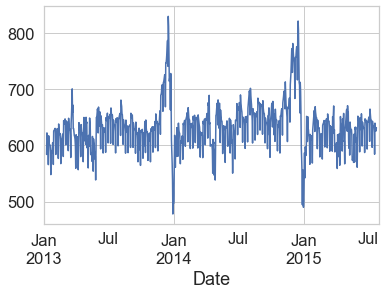

In [23]:
# Get mean daily customers across all stores
average_daily_customers = data[['Customers']].resample('D').mean()

# Get 15 day rolling mean
average_daily_customers['Customers'].rolling(window=15, center=True).mean().plot()

### 3.4 Identify the date with largest drop in sales from the same date in the previous week

In [24]:
# Get average daily sales difference with previous week
average_daily_sales = data[['Sales', 'Open']].resample('D').mean()
average_daily_sales['DiffVsLastWeek'] = average_daily_sales[['Sales']].diff(periods=7)

print (average_daily_sales.sort_values(by='DiffVsLastWeek').head())
# Unsurprisingly, this day is Dec. 25 and Dec. 26 in 2014 and 2015.
# When the store is closed and there are many sales in the preceding week. How, about when the store is open?

print (average_daily_sales[average_daily_sales.Open == 1].sort_values(by='DiffVsLastWeek').head())
# The top values are Dec. 24 and then 2013-12-09 and 2013-10-14
# where on average sales were 4k lower than the same day in the previous week.

                 Sales      Open  DiffVsLastWeek
Date                                            
2015-04-06  244.772197  0.028700   -10850.701345
2013-12-25  127.878924  0.015247   -10804.564126
2013-12-26  169.145291  0.017040   -10360.247534
2014-12-25  166.188235  0.017112   -10323.878075
2014-04-21  216.132735  0.028700   -10262.018834
                  Sales  Open  DiffVsLastWeek
Date                                         
2013-12-24  4693.101345   1.0    -7014.515695
2014-12-24  4933.386096   1.0    -5209.272727
2013-12-09  6822.938117   1.0    -4811.537220
2013-10-14  5893.636771   1.0    -4027.798206
2015-04-20  5909.294170   1.0    -4023.443049


### 3.5 Compute the total sales up until Dec. 2014

In [25]:
# Get total daily sales across all stores
total_daily_sales = data[['Sales']].resample('D').sum()

# Get total sales up until Dec 2014
total_daily_sales.expanding(min_periods=1).sum()['2014-12'].head()

/var/folders/6z/smv4kfs12fv5tpcrw97pcfd40000gn/T/ipykernel_10791/1088660041.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  total_daily_sales.expanding(min_periods=1).sum()['2014-12'].head()


,Sales
Date,
2014-12-01,4.291837e+09
2014-12-02,4.300681e+09
2014-12-03,4.308939e+09
2014-12-04,4.317493e+09
2014-12-05,4.327295e+09


### 3.6 When were the largest differences between 15-day moving/rolling averages?

Hint: Using `rolling_mean` and `diff`

In [26]:
# Get mean daily sales across all stores
average_daily_sales = data[['Sales']].resample('D').mean()

# Get largest 15-day rolling average difference
average_daily_sales.rolling( window=15).mean().diff(1).sort_values(by='Sales').head()

# Unsurprisingly, they occur at the beginning of every year after the holiday season.

,Sales
Date,
2014-01-01,-773.446039
2015-01-01,-668.394774
2013-12-31,-663.000538
2014-01-05,-596.739073
2014-05-01,-585.158326
